# Opis

Analiza relacji między polskimi streamerami. Wierzchołki oznaczają streamerów, a krawędź oznacza wzajemne obserwowanie się (follow).

- Czy środowisko polskich streamerów jest zamknięte?
- Czy różnica między długościami istnienia dwóch kont ma wpływ na prawdopodobieństwo wystąpienia relacji między nimi?

<h2>Preprocessing<h2>

In [15]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO, BytesIO
import zipfile
import requests
from collections import Counter
import seaborn as sns
from scipy import stats


In [16]:
#Download zip
r = requests.get("https://snap.stanford.edu/data/twitch_gamers.zip")
archive = zipfile.ZipFile(BytesIO(r.content), 'r')

In [17]:
#Load rawdata
twitch_rawdata_edges = StringIO(str(archive.read('large_twitch_edges.csv'), 'utf-8'))
twitch_rawdata_feature = StringIO(str(archive.read('large_twitch_features.csv'), 'utf-8'))

twitch_raw_data_df_feature = pd.read_csv(twitch_rawdata_feature, sep=",")
twitch_raw_data_df_edges = pd.read_csv(twitch_rawdata_edges, sep=",")

In [18]:
#Get only polish streamers
twitch_filter_PL = twitch_raw_data_df_feature["language"] == "PL"
twitch_df_feature = twitch_raw_data_df_feature[twitch_filter_PL]

# Get only edges where both streamers are from Poland
twitch_filter_edges = twitch_raw_data_df_edges["numeric_id_1"].isin(twitch_df_feature["numeric_id"])
twitch_filter_edges2 = twitch_raw_data_df_edges["numeric_id_2"].isin(twitch_df_feature["numeric_id"])
twitch_filter_edges_pair = twitch_filter_edges & twitch_filter_edges2
twitch_df_edges = twitch_raw_data_df_edges[twitch_filter_edges_pair]

In [19]:
#Create graph
twitch_graph = nx.from_pandas_edgelist(twitch_df_edges, 'numeric_id_1', 'numeric_id_2')

for index, node in twitch_df_feature.iterrows():
    twitch_graph.add_node(node["numeric_id"], 
                          views=node["views"],
                          mature=node["mature"],
                          life_time=node["life_time"],
                          created_at=node["created_at"],
                          updated_at=node["updated_at"],
                          dead_account=node["dead_account"],
                          language=node["language"],
                          affiliate=node["affiliate"])

In [20]:
print(twitch_graph)
print(list(twitch_graph.nodes(data=True))[0])

Graph with 944 nodes and 8959 edges
(96766, {'views': 628, 'mature': 0, 'life_time': 635, 'created_at': '2017-01-14', 'updated_at': '2018-10-11', 'dead_account': 0, 'language': 'PL', 'affiliate': 0})


<h2>Rozkład stopni wyjściowych i wejściowych<h2>

In [21]:
degree_sequence = sorted((d for n, d in twitch_graph.degree()), reverse=True)

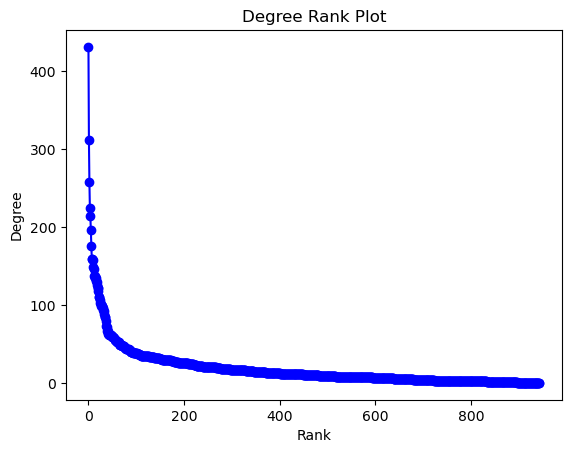

In [22]:
plt.plot(degree_sequence, "b-", marker="o")
plt.title("Degree Rank Plot")
plt.xlabel("Rank")
plt.ylabel("Degree")
plt.show()

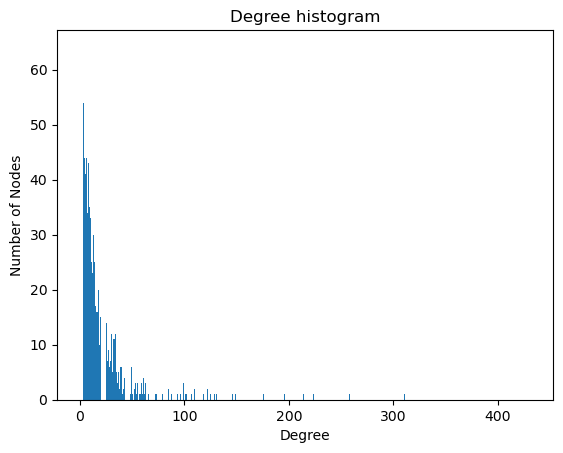

In [23]:
plt.bar(*np.unique(degree_sequence, return_counts=True))
plt.title("Degree histogram")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.show()

<h2>Rozkład długości najkrótszych ścieżek<h2>

In [24]:
p = dict(nx.shortest_path_length(twitch_graph))
p_df = pd.json_normalize(p, sep='_')
p_flat = p_df.to_dict(orient='records')[0]

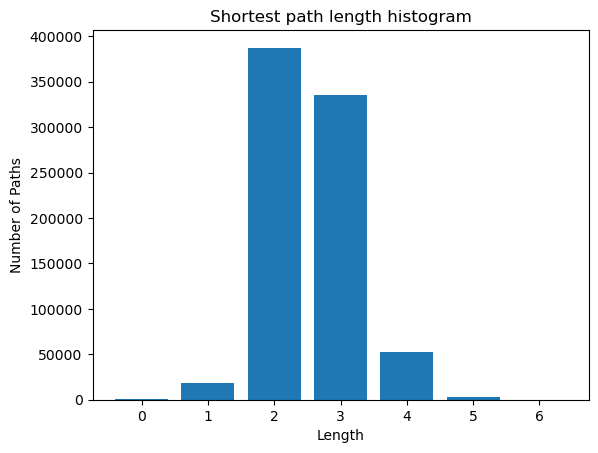

In [25]:
plt.bar(*np.unique(list(p_flat.values()), return_counts=True))
plt.title("Shortest path length histogram")
plt.xlabel("Length")
plt.ylabel("Number of Paths")
plt.show()

<h2>Rozkład pośrednictwa<h2>

In [26]:
centr = nx.betweenness_centrality(twitch_graph)

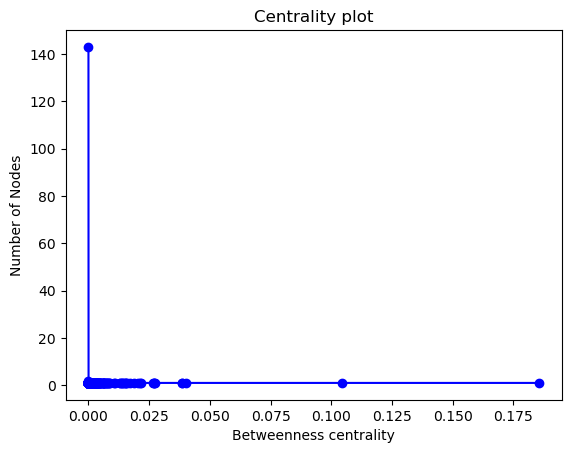

In [27]:
plt.plot(*np.unique(list(centr.values()), return_counts=True), "b-", marker="o")
plt.title("Centrality plot")
plt.xlabel("Betweenness centrality")
plt.ylabel("Number of Nodes")
plt.show()

<h2>Rozkład lokalnych współczynników grupowania<h2>

In [28]:
clusters = nx.clustering(twitch_graph)

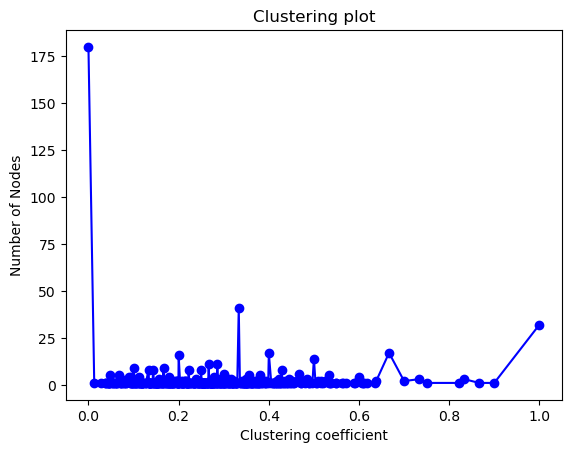

In [29]:
plt.plot(*np.unique(list(clusters.values()), return_counts=True), "b-", marker="o")
plt.title("Clustering plot")
plt.xlabel("Clustering coefficient")
plt.ylabel("Number of Nodes")
plt.show()

<h2>Miary oceny sieci: gęstość, współczynnik centralizacji, promień<h2>

In [41]:
dens = nx.density(twitch_graph)
print(f"Density: {dens}")

Density: 0.02012824199723206


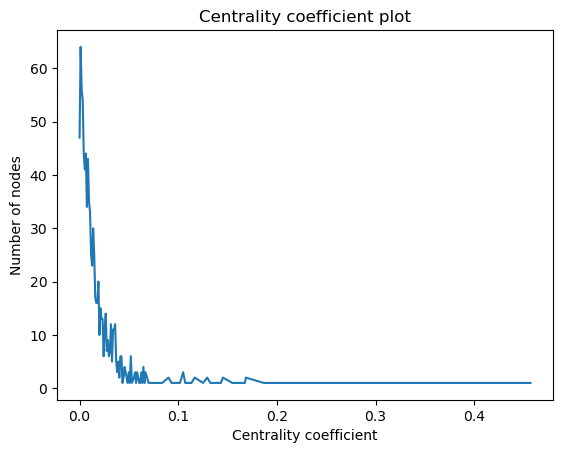

In [31]:
degree_centrality_list = list(nx.degree_centrality(twitch_graph).values())
plt.plot(*np.unique(degree_centrality_list, return_counts=True))
plt.title("Centrality coefficient plot")
plt.xlabel("Centrality coefficient")
plt.ylabel("Number of nodes")
plt.show()

In [42]:
# Gdy graf jest rozłączny, to liczymy promień dla największego podgrafu
if not nx.is_connected(twitch_graph):
    twitch_graph_connected_list = max(nx.connected_components(twitch_graph), key=len)
    twitch_graph_connected = twitch_graph.subgraph(twitch_graph_connected_list) 
else:
    twitch_graph_connected = twitch_graph

radius = nx.radius(twitch_graph_connected)
print(f"Radius: {radius}")

Radius: 4


<h2>Podział sieci na moduły<h2>

In [33]:
communities = nx.algorithms.community.greedy_modularity_communities(twitch_graph, weight='weight')

In [34]:
colors = range(len(communities))

node_color_map = {}
for i, community in enumerate(communities):
    for node in community:
        node_color_map[node] = colors[i]

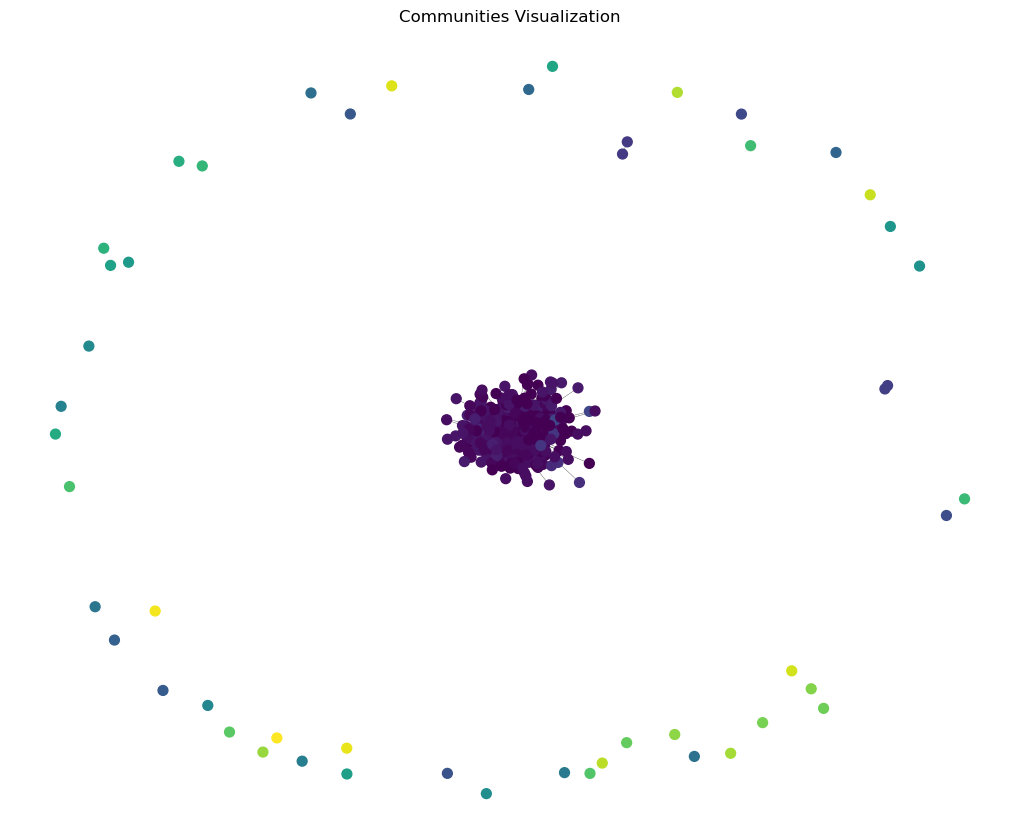

In [35]:
plt.figure(figsize=(10, 8))
pos = nx.layout.spring_layout(twitch_graph)
nx.draw(
    twitch_graph, 
    pos, 
    node_color=[node_color_map[node] for node in twitch_graph.nodes()], 
    with_labels=False, 
    node_size=50,
    width=0.2
)
plt.title('Communities Visualization')
plt.show()

<h2>Liczba krawędzi dla martwych kont<h2>

Liczba martwych kont: 29


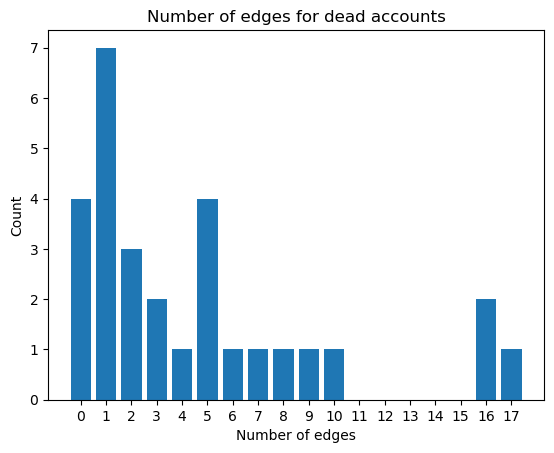

In [36]:
nodes_dead_account = [node for node, attr in twitch_graph.nodes(data=True) if attr.get('dead_account') == 1]

nodes_dead_account_degree = {node: twitch_graph.degree(node) for node in nodes_dead_account}

counts = Counter(nodes_dead_account_degree.values())

print(f"Liczba martwych kont: {len(nodes_dead_account_degree)}")

labels, values = zip(*Counter(counts).items())
indexes = np.arange(len(labels))

min_value = np.min(labels)
max_value = np.max(labels)

plt.bar(labels, values)
plt.xticks(range(min_value, max_value+1))
plt.title("Number of edges for dead accounts")
plt.xlabel("Number of edges")
plt.ylabel("Count")
plt.show()

Martwe konta stanowią niewielką część społeczności.

<h2>Korelacja ilości oglądających dla danego wierzchołka do średniej liczby oglądających jego sąsiadów<h2>

Współczynnik pearsona: -0.08657570447771053
Współczynnik P: 0.007779875160392916


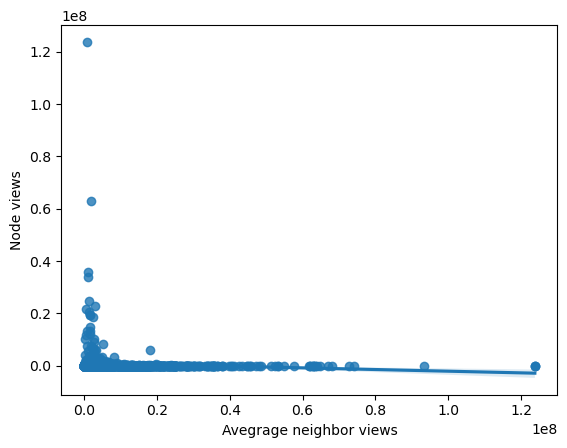

In [37]:
df = pd.DataFrame(columns=['avg_neighbor_views', 'node_views'])
for node in twitch_graph.nodes():
    count_nodes = 0
    sum_views = 0
    for neighbor in twitch_graph.neighbors(node):
        count_nodes += 1
        sum_views += twitch_graph.nodes[neighbor].get('views')

    if count_nodes == 0:
        avg_views = 0
    else:
        avg_views = sum_views/count_nodes

    df.loc[len(df.index)] = [avg_views, twitch_graph.nodes[node].get('views')]

sns.regplot(x="avg_neighbor_views", y="node_views", data=df)
plt.xlabel("Avegrage neighbor views")
plt.ylabel("Node views")

pearson_coef, p_value = stats.pearsonr(df['avg_neighbor_views'], df['node_views'])
print(f"Współczynnik pearsona: {pearson_coef}")
print(f"Współczynnik P: {p_value}")

Korelacja między ilością widzów danego kanału oraz średnią ilością widzów jego sąsiadów nie występuje.

<h2>Różnica między datami stworzeń kont dla wszystkich par wierzchołków<h2>

In [ ]:
#<1, 1-2, 2-3, 3-4, 4-5, 5>
differences = [0, 0, 0, 0, 0, 0]
for n1, n2, a in twitch_graph.edges(data=True):
    difference = np.datetime64(twitch_graph.nodes[n1]["created_at"]) - np.datetime64(twitch_graph.nodes[n2]["created_at"])
    difference_number = abs(int(difference/np.timedelta64(1,'D')))
    if difference_number < 365:
        differences[0] += 1
    elif 365 <= difference_number < 730:
        differences[1] += 1
    elif 730 <= difference_number < 1095:
        differences[2] += 1
    elif 1095 <= difference_number < 1460:
        differences[3] += 1
    elif 1460 <= difference_number < 1825:
        differences[4] += 1
    elif difference_number >= 1825:
        differences[5] += 1
differences = [difference/sum(differences) for difference in differences]
plt.bar(["<1", "1-2", "2-3", "3-4", "4-5", "5>"], differences)
plt.title("Differences between dates of creation of every pair of accounts")
plt.xlabel("Years")
plt.ylabel("Percentages")
plt.show()

Użytkownicy znacznie chętniej followują konta o podobnym stażu. Im większa różnica, tym mniejsza szansa istnienia relacji.